In [1]:
import sys
from pathlib import Path

import polars as pl
import geopandas as gpd
import h3ronpy.polars
from h3ronpy.pandas.vector import cells_dataframe_to_geodataframe
import folium
import altair as alt

# Add the project root to sys.path
root_path = Path().resolve().parent
sys.path.append(str(root_path))

# Load variables
from scripts import PROCESSED_DATA_DIR, FULL_DATASET

# Exploración de los datos

In [3]:
data = pl.read_csv(PROCESSED_DATA_DIR / FULL_DATASET)
print(data.shape)
data.describe()

(1021, 100)


shape: (9, 101)
┌────────────┬───────────┬───────────┬─────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ hex_id    ┆ cost_of_l ┆ train   ┆ … ┆ 13_1 Pair ┆ 13_1      ┆ 13_1 Pair ┆ 13_1 Pair │
│ ---        ┆ ---       ┆ iving     ┆ ---     ┆   ┆ of Jeans  ┆ Summer    ┆ of Nike   ┆ of Men    │
│ str        ┆ str       ┆ ---       ┆ f64     ┆   ┆ (Levis    ┆ Dress in  ┆ Running   ┆ Leather   │
│            ┆           ┆ f64       ┆         ┆   ┆ 501 …     ┆ a Chain   ┆ Shoe…     ┆ Busin…    │
│            ┆           ┆           ┆         ┆   ┆ ---       ┆ S…        ┆ ---       ┆ ---       │
│            ┆           ┆           ┆         ┆   ┆ f64       ┆ ---       ┆ f64       ┆ f64       │
│            ┆           ┆           ┆         ┆   ┆           ┆ f64       ┆           ┆           │
╞════════════╪═══════════╪═══════════╪═════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 1021      ┆ 510.0     ┆ 1021.0  ┆ … ┆ 1021.0    ┆ 1021.0    ┆ 1021.0    ┆ 1021.0    │
│ null_count ┆ 0         ┆ 511.0     ┆ 0.0     ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ mean       ┆ null      ┆ 0.434846  ┆ 0.49951 ┆ … ┆ 72.13869  ┆ 57.953416 ┆ 109.19785 ┆ 98.718749 │
│            ┆           ┆           ┆         ┆   ┆           ┆           ┆ 8         ┆           │
│ std        ┆ null      ┆ 0.19183   ┆ null    ┆ … ┆ 3.05821   ┆ 4.294371  ┆ 1.107235  ┆ 9.836808  │
│ min        ┆ 8866d14d0 ┆ 0.152048  ┆ 0.0     ┆ … ┆ 63.602024 ┆ 54.356029 ┆ 106.70083 ┆ 77.422593 │
│            ┆ 5fffff    ┆           ┆         ┆   ┆           ┆           ┆ 3         ┆           │
│ 25%        ┆ null      ┆ 0.296405  ┆ null    ┆ … ┆ 72.398452 ┆ 54.356029 ┆ 108.7125  ┆ 95.09373  │
│ 50%        ┆ null      ┆ 0.384109  ┆ null    ┆ … ┆ 72.398452 ┆ 54.647533 ┆ 108.7125  ┆ 95.09373  │
│ 75%        ┆ null      ┆ 0.53506   ┆ null    ┆ … ┆ 73.832296 ┆ 63.149689 ┆ 110.16178 ┆ 108.77160 │
│            ┆           ┆           ┆         ┆   ┆           ┆           ┆ 6         ┆ 5         │
│ max        ┆ 888f76d6e ┆ 1.0       ┆ 1.0     ┆ … ┆ 73.832296 ┆ 63.149689 ┆ 110.16178 ┆ 108.77160 │
│            ┆ dfffff    ┆           ┆         ┆   ┆           ┆           ┆ 6         ┆ 5         │
└────────────┴───────────┴───────────┴─────────┴───┴───────────┴───────────┴───────────┴───────────┘

## Distribución de los datos agregados de movilidad

In [15]:
features = ['devices_count', 'duration_s']

chart = alt.hconcat()
for feature in features:
    chart |= (
        data
        .select(feature)
        .to_series()
        .qcut(50)
        .value_counts(sort=True)
        .plot.bar(x= feature, y='count')
        .properties(title=f'{feature} distribution', width = 500)
    )
(
    chart
    .configure_axisX(labels = False)
    .configure_axisY(title = '')
)

alt.HConcatChart(...)

In [16]:
# Parse hex_id
data = data.with_columns(pl.col('hex_id').h3.cells_parse().alias('cell'))
# Convert dataframe to geopandas dataframe
gdf = cells_dataframe_to_geodataframe(data.to_pandas(), 'cell')

## Mapa de calor de los datos de movilidad

In [17]:
def plot_heatmap(gdf):
    center = [gdf['lat'].mean(), gdf['lon'].mean()]
    map = folium.Map(location=center, tiles="Cartodb dark_matter", zoom_start=7)

    heat_data = [[point.centroid.xy[1][0], point.centroid.xy[0][0]] for point in gdf.geometry]
    folium.plugins.HeatMap(heat_data).add_to(map)
    return map

plot_heatmap(gdf)

## Mapa de los datos de movilidad

The colors here represent the dataset from which belongs to (blue -> Train, red -> Test)
Los colores aquí representan:  
- Azul -> Train Dataset
- Rojo -> Test Dataset

In [12]:
def hexagons_map(gdf):
    center = [gdf['lat'].mean(), gdf['lon'].mean()]
    map = folium.Map(location=center, zoom_start=8, tiles='CartoDB Positron')
    return map

map = hexagons_map(gdf)
for _, r in gdf.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    color = "blue" if r["train"] else "red"
    geo_j = folium.GeoJson(
        data=geo_j,
        style_function=lambda x, color=color: {"fillColor": color, "color": "gray", "weight": 1.5, "fillOpacity": 0.3},
    )
    folium.Popup(r["hex_id"]).add_to(geo_j)
    geo_j.add_to(map)
map

# Análisis de nulos

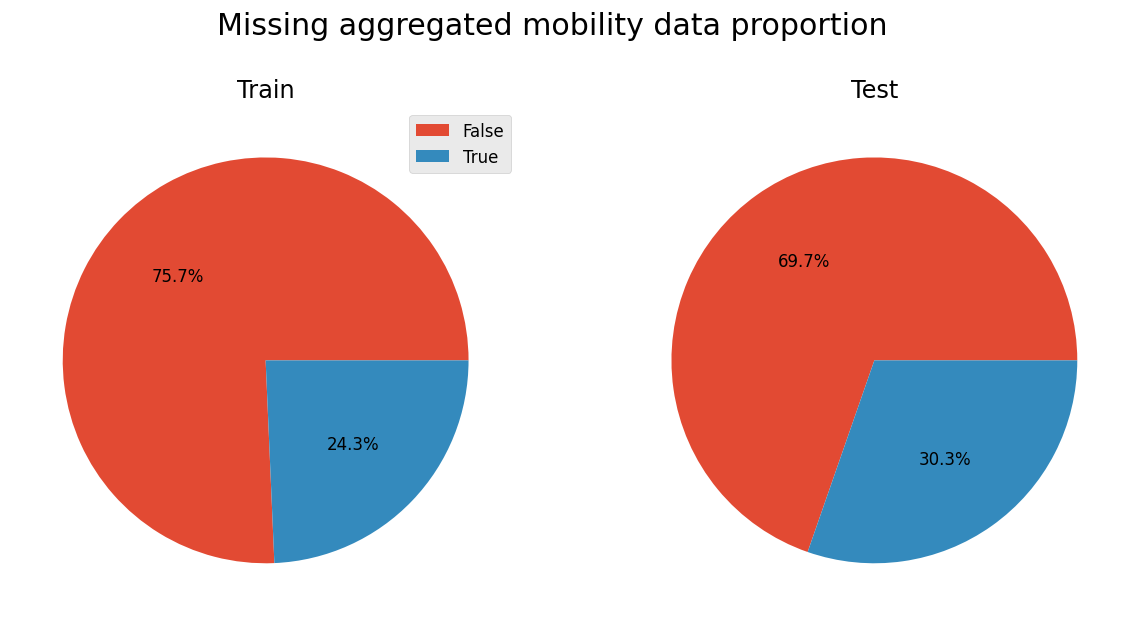

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

data.query("train == True")['devices_count'].isnull().value_counts().plot.pie(ax=ax[0], title='Train', autopct='%1.1f%%', legend=True, labels=None)
data.query("train == False")['devices_count'].isnull().value_counts().plot.pie(ax=ax[1], title='Test', autopct='%1.1f%%', labels=None)
ax[0].set_yticklabels([])
ax[1].set_yticklabels([])
ax[0].set_ylabel('')
ax[1].set_ylabel('')
plt.suptitle('Missing aggregated mobility data proportion', fontsize=18)
plt.show()

Los colores aquí representan:  
- Rojo -> Nulo
- Azul -> No nulo

In [13]:
map = hexagons_map(gdf)
for _, r in gdf.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    color = "blue" if r["devices_count"] > 0 else "red"
    geo_j = folium.GeoJson(
        data=geo_j,
        style_function=lambda x, color=color: {"fillColor": color, "color": "gray", "weight": 1.5, "fillOpacity": 0.3},
    )
    folium.Popup(r["hex_id"]).add_to(geo_j)
    geo_j.add_to(map)
map

## Conclusiones:
- Nulos en `cost_of_living` son del set de testeo.
- Nulos en las variables agregadas de movilidad (`devices_count` y `duration_s`) estan dados, grosso modo, en zonas no residenciales. Imputarlos con **0** es una buena opción ya que indica que no hay registos de movilidad en esas zonas.
- 

In [ ]:
# Convert to long format for Altair
corr_mat = (
    pipe.fit_transform(full_data)
    .to_pandas()
    .corr()
    .reset_index()
)
correlation_long = (
    corr_mat
    .melt(id_vars = 'index', var_name="feature", value_name="correlation")
)
correlation_long

index         feature  correlation
0       devices_count   devices_count     1.000000
1     pop_density_km2   devices_count     0.229044
2          duration_s   devices_count    -0.045995
3                 lat   devices_count    -0.044090
4                 lon   devices_count    -0.050177
...               ...             ...          ...
5324         district  cost_of_living    -0.009469
5325    neighbourhood  cost_of_living    -0.056590
5326     closest_city  cost_of_living    -0.324653
5327            train  cost_of_living          NaN
5328   cost_of_living  cost_of_living     1.000000

[5329 rows x 3 columns]

In [ ]:
alt.data_transformers.disable_max_rows()
# Heatmap using Altair
heatmap = (
    alt.Chart(correlation_long)
    .mark_rect()
    .encode(
        x="index:O",
        y="feature:O",
        color="correlation:Q",
        tooltip=["index", "feature", "correlation"]
    )
    .properties(
        width=800,
        height=800
    )
    .configure_axisX(title = None)
    .configure_axisY(title = None)
)

# Show the plot
heatmap.show()

alt.Chart(...)